# Dictator Game in DIMA

{
  "agents": [
    {
      "name": "Ace",
      "characteristics": [
        {
          "name": "intelligence",
          "value": 0.92
        },
        {
          "name": "charisma",
          "value": 0.1
        }
      ],
      "knowledgeBase": []
    },
    {
      "name": "Ben",
      "characteristics": [
        {
          "name": "intelligence",
          "value": 0.7
        },
        {
          "name": "charisma",
          "value": 0.12
        }
      ],
      "knowledgeBase": []
    },
    {
      "name": "Cara",
      "characteristics": [
        {
          "name": "intelligence",
          "value": 0.94
        },
        {
          "name": "charisma",
          "value": 0.15
        }
      ],
      "knowledgeBase": []
    },
    {
      "name": "Dan",
      "characteristics": [
        {
          "name": "intelligence",
          "value": 0.8
        },
        {
          "name": "charisma",
          "value": 0.05
        }
      ],
      "knowledgeBase": 

C:\Users\Ines Lobo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(2, array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1]), array([[0.85875, 0.145  ],
       [0.17   , 0.9    ]]))


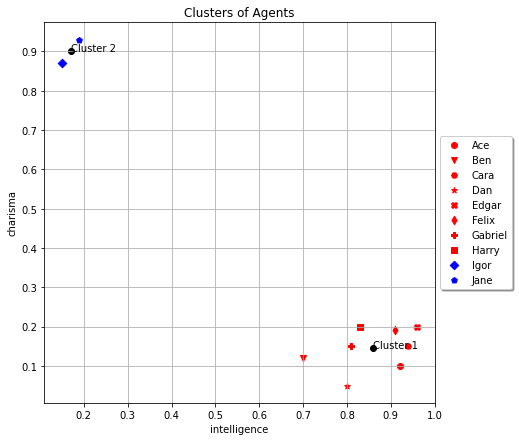

Before Normative Fit
[]
After Normative Fit
[<__main__.SocialGroup object at 0x000002209F606F40>, <__main__.SocialGroup object at 0x000002209F606E80>]
Fitness Group 1
0.5631609793429289
Fitness Group 2
0.6594736318195866
Salient Identity
Group 1
Salience
0.5479380198021154
Previous accessibility
0.9729687245757423
0.2309369199531622
New accessibility
0.9732586294930159
0.2297120809129905


C:\Users\Ines Lobo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


simulation 0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10
simulation 11
simulation 12
simulation 13
simulation 14
simulation 15
simulation 16
simulation 17
simulation 18
simulation 19
simulation 20
simulation 21
simulation 22
simulation 23
simulation 24
simulation 25
simulation 26
simulation 27
simulation 28
simulation 29
Salience Plots


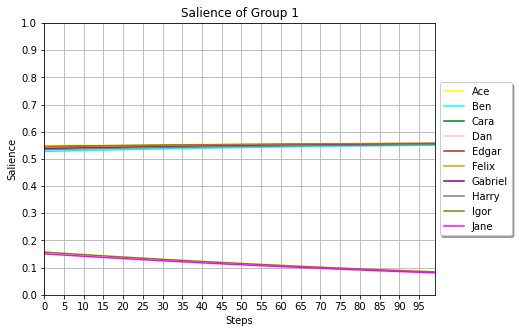

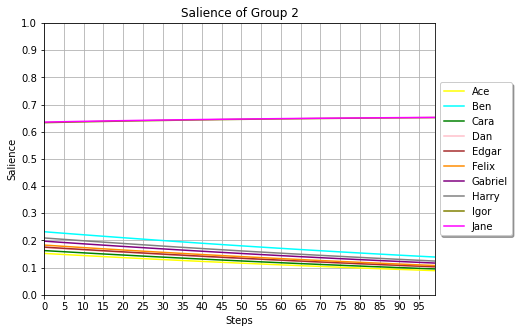

Accessibility Plots


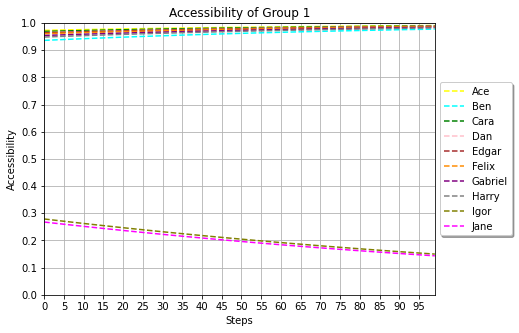

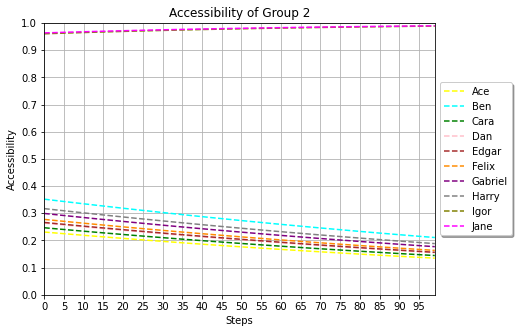

In [1]:
%run ./DynamicIdentityModelForAgents.ipynb

In [2]:
class DictatorGameAgent:
    def __init__(self):
        self.moneyReceived = 0
        self.moneyReceivedIngroupMember = []
        self.moneyReceivedOutgroupMember = []

def addScenarioAgents(agents):
    for a in agents:
        a.scenario = DictatorGameAgent()
        
class DictatorGame:
    def __init__(self, baselineOffer, potSize, valenceInGroup, valenceOutGroup):
        self.baselineOffer = baselineOffer
        self.potSize = potSize
        self.valenceInGroup = valenceInGroup
        self.valenceOutGroup = valenceOutGroup
        
        self.groupsAverageOffersToIngroup = []
        self.groupsAverageOffersToOutgroup = []
        self.groupsAverageWealthSteps = []
    
    def offer(self, agentOffering, agentReceiving, salience, inGroupBool):

        if salience is None:
            offer = self.baselineOffer
        else: #social identity
            if inGroupBool: #in-group favoritism
                offer = self.baselineOffer * (1 + salience)
                agentOffering.scenario.moneyReceivedIngroupMember.append(offer)
            else: #out-group discrimination
                offer = self.baselineOffer * (1 - salience)
                agentOffering.scenario.moneyReceivedOutgroupMember.append(offer)
        
        agentOffering.scenario.moneyReceived += self.potSize - offer
        agentReceiving.scenario.moneyReceived += offer

        #offer --> payoff --> impact
        #return -0.2*(offer/(self.baselineOffer*2)) + 0.1
        return 0.01
    
    def updateAvgWealth(self, groupIdx, agents, s):
        sumMoney = 0
        lenAgents = len(agents)
        for a in agents:
            sumMoney += a.scenario.moneyReceived
        avg = sumMoney/lenAgents
        if len(self.groupsAverageWealthSteps) <= groupIdx:            
            self.groupsAverageWealthSteps.append([0] * numSteps)
        self.groupsAverageWealthSteps[groupIdx][s] += avg
    
    def updateAvgIngroupOffers(self, groupIdx, agents, s):
        ingroupOfferTotal = 0
        lenAgents = len(agents)
        for a in agents:
            lenInteractions = len(a.scenario.moneyReceivedIngroupMember)
            if lenInteractions != 0:
                ingroupOfferTotal += np.sum(a.scenario.moneyReceivedIngroupMember)/lenInteractions
        avg = ingroupOfferTotal/lenAgents
        if len(self.groupsAverageOffersToIngroup) <= groupIdx:            
            self.groupsAverageOffersToIngroup.append([0] * numSteps)
        self.groupsAverageOffersToIngroup[groupIdx][s] += avg
        
    def updateAvgOutgroupOffers(self, groupIdx, agents, s):
        outgroupOfferTotal = 0
        lenAgents = len(agents)
        for a in agents:
            lenInteractions = len(a.scenario.moneyReceivedOutgroupMember)
            if lenInteractions != 0:
                outgroupOfferTotal += np.sum(a.scenario.moneyReceivedOutgroupMember)/lenInteractions
        avg = outgroupOfferTotal/lenAgents       
        if len(self.groupsAverageOffersToOutgroup) <= groupIdx:            
            self.groupsAverageOffersToOutgroup.append([0] * numSteps)
        self.groupsAverageOffersToOutgroup[groupIdx][s] += avg

    
def playScenario(giver, idxGiver):
    inGroup = False
    idxReceiver = np.random.choice([i for i in range(0,len(context.agentsPresent)) if i != idxGiver])
    receiver = context.agentsPresent[idxReceiver]
    #check if in group or out group
    if clustersCt[1][idxReceiver] == clustersCt[1][idxGiver]:
        inGroup = True
    else:
        inGroup = False
    #check if salient identity of giver is empty
    if giver.salientIdentity is None:
        salience = None
    else:
        salience = giver.salientIdentity.salience
        
    return scenario.offer(giver, receiver, salience, inGroup)

def auxPlotScenario(s):
    for sg in range(0, clustersCt[0]):
        agentsGroup = []
        for a, c in enumerate(clustersCt[1]):
            if c == sg:
                agentsGroup.append(context.agentsPresent[a])
        scenario.updateAvgWealth(sg, agentsGroup, s)
        scenario.updateAvgIngroupOffers(sg, agentsGroup, s)
        scenario.updateAvgOutgroupOffers(sg, agentsGroup, s)

def auxClearScenario():
    for a in context.agentsPresent:
        a.scenario.moneyReceived = 0
        a.scenario.moneyReceivedIngroupMember = []
        a.scenario.moneyReceivedOutgroupMember = []
        
def cycleScenario():
    global clustersCt
    clustersCt = clustering()
    #Run simulation
    for r in range(0, numRuns):
        for s in range(0, numSteps):
            #For each agent
            for idxAgent, a in enumerate(context.agentsPresent):
                normativeFit(a, idxAgent)
                comparativeFit(a)
                salienceSocialGroup(a)
                salientActiveIdentity(a, idxAgent)
                listGraphics(a, s)
                valence = playScenario(a, idxAgent) #added this function
                updateAccessibility(a, valence) #update accessibility
            auxPlotScenario(s) #added this function
        clearSim()
        auxClearScenario() #added this function


## Dictator Game: Wealth, Salience and Accessibility Plots

In [3]:
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Bahnschrift']
plt.rcParams["font.weight"] = "normal"

def plotStyle(plot):
    plot.grid(color='gray', linewidth=1.0)
    plot.spines['top'].set_visible(False)
    plot.spines['right'].set_visible(False)
    plot.spines['bottom'].set_visible(False)
    plot.spines['left'].set_visible(False)
    
def showAverageWealthGroupsPlots():
    lenColors = len(colors)
    fig = plt.figure(figsize = (7,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.yaxis.set_major_locator(plt.MultipleLocator(2000))
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    plotStyle(ax)
    for i, sgWealth in enumerate(scenario.groupsAverageWealthSteps):
        colorPlot = colors[i%lenColors]
        wealthSims = [x / numRuns for x in sgWealth]
        plt.plot(wealthSims, color=colorPlot, linewidth=2.5, label='Avg Wealth of Agent in Group ' + str(i+1))
    plt.title('Average Social Group Wealth:\nEach agent in the environment uses their active identity\nto play the Dictator Game and gather wealth')
    plt.legend(loc='upper left', fancybox=True)
    plt.xlim(0, numSteps-1)
    plt.ylim(0, 12000)
    plt.xlabel("Number of Steps")
    plt.ylabel("Money (€)")
    plt.show()
    
def showAverageOffersInGroupsPlots():
    lenColors = len(colors)
    fig = plt.figure(figsize = (7,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.yaxis.set_major_locator(plt.MultipleLocator(5))
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    plotStyle(ax)
    for i, sgOffers in enumerate(scenario.groupsAverageOffersToIngroup):
        colorPlot = colors[i%lenColors]
        offersSims = [x / numRuns for x in sgOffers]
        plt.plot(offersSims, color=colorPlot, linewidth=2.5, label='Avg Offer of Agent in Group ' + str(i+1) +' to In-Group Member')
    plt.title('Average Offer to In-Group Members:\nEach dictator agent offers a specific amount of money\nto their in-group members according to their active identity')
    plt.legend(loc='upper left', fancybox=True)
    plt.xlim(0, numSteps-1)
    plt.ylim(0, 50)
    plt.xlabel("Number of Steps")
    plt.ylabel("Money (€)")
    plt.show()

def showAverageOffersOutGroupsPlots():
    lenColors = len(colors)
    fig = plt.figure(figsize = (7,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.yaxis.set_major_locator(plt.MultipleLocator(5))
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    plotStyle(ax)
    for i, sgOffers in enumerate(scenario.groupsAverageOffersToOutgroup):
        colorPlot = colors[i%lenColors]
        offersSims = [x / numRuns for x in sgOffers]
        plt.plot(offersSims, color=colorPlot, linewidth=2.5, label='Avg Offer of Agent in Group ' + str(i+1) +' to Out-Group Member')
    plt.title('Average Offer to Out-Group Members:\nEach dictator agent offers a specific amount of money\nto their out-group members according to their active identity')
    plt.legend(loc='upper left', fancybox=True)
    plt.xlim(0, numSteps-1)
    plt.ylim(0, 50)
    plt.xlabel("Number of Steps")
    plt.ylabel("Money (€)")
    plt.show()
    
    
def printClustering():
    fig = plt.figure(figsize = (7,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
    plotStyle(ax)
    
    lenColorsClusters = len(colors)
    lenSymbolsAgents = len(plotSymbols)
    for i in range(0, clustersCt[0]):
        x = []
        y = []
        symbol = plotSymbols[i%lenSymbolsAgents]
        for j in range(0, len(dataAgents)):
            if(clustersCt[1][j] == i):
                #plotting the agents
                x.append(dataAgents[j][0])
                y.append(dataAgents[j][1])
        color = colors[i%lenColorsClusters]
        plt.scatter(x, y, c=color, marker=symbol, s = 50, label="Agents in Social Group " + str(i+1))

    #plotting the centroids
    for c in range(0, len(clustersCt[2])):
        x = clustersCt[2][c][0]
        y = clustersCt[2][c][1]
        plt.scatter(x, y, marker='X', s = 50, c='black')
        plt.annotate("Center\nSocial Group " + str(c+1), (x, y+0.01), ha='center')
    
    plt.title('Social Groups in the Environment:\nResult from the interpretation of the social context')
    themeKeys = list(context.theme)  
    plt.xlabel(themeKeys[0])
    plt.ylabel(themeKeys[1])
    plt.legend(loc='upper left', fancybox=True)           
    plt.show()

    
def showSalienceAccessibilityPlots(salience=True):  
    numGroups = len(clustersCt[2])
    lenColors = len(colors)
    for j in range(0, numGroups):
        fig = plt.figure(figsize = (7,5))
        ax = fig.add_subplot(1, 1, 1)
        ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
        ax.xaxis.set_major_locator(plt.MultipleLocator(5))
        plotStyle(ax)
        for sg in range(0, clustersCt[0]):
            agentsGroup = []
            for a, c in enumerate(clustersCt[1]):
                if c == sg:
                    agentsGroup.append(context.agentsPresent[a])
            lenAgents = len(agentsGroup)
            salienceSimsAgents = [0]*numSteps
            accessibilitySimsAgents = [0]*numSteps
            for agent in agentsGroup:                
                #plot - scale axis
                sgKB = agent.knowledgeBase[j]
                salienceSimsAgents += np.array([x / numRuns for x in sgKB.salienceSteps])
                accessibilitySimsAgents += np.array([x / numRuns for x in sgKB.accessibilitySteps])
            
            colorPlot = colors[sg%lenColors]
            if salience:
                salienceSims = np.array(salienceSimsAgents/lenAgents)
                plt.plot(salienceSims, color=colorPlot, linewidth=2.5, label='Avg Salience of Social Identity ' + str(j+1) + ' for Agents in Group ' + str(sg+1))
                plt.title('Average Salience of Social Identity ' + str(j+1) + '\nEach agent has stored this identity in their knowledge base')
            else:
                accessibilitySims = np.array(accessibilitySimsAgents/lenAgents)             
                plt.plot(accessibilitySims,'--', linewidth=2.5, color=colorPlot, label='Avg Accessibility of Social Identity ' + str(j+1) + ' for Agents in Group ' + str(sg+1))
                plt.title('Average Accessibility of Social Identity ' + str(j+1) + '\nEach agent has stored this identity in their knowledge base')
            
        plt.legend(fancybox=True)
        plt.xlim(0, numSteps-1) 
        plt.ylim(0, 1)
        plt.xlabel("Number of Steps")
        if salience:
            plt.ylabel("Salience")
        else:
            plt.ylabel("Accessibility")                
        plt.show()
    

In [4]:
def initAgentsLoop(numA, pGroup = 1):
    agents = []
    limit = numA*pGroup
    for i in range(0, numA):
        nameA = str(i)
        charA = {}
        kbA=[]           
        for j in range(0,2):
            if i < limit:
                charA["Characteristic " + str(j+1)] = np.around(np.random.uniform(0,0.3),3)
            else:
                charA["Characteristic " + str(j+1)] = np.around(np.random.uniform(0.7,1),3)
        agents.append(Agent(nameA, charA, kbA))
    return agents
    
def initContextLoop(numC):
    theme = {}
    for t in range(0, numC):
        theme["Characteristic " + str(t+1)] = 1/numC
    return SocialContext(agents, theme)


C:\Users\Ines Lobo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


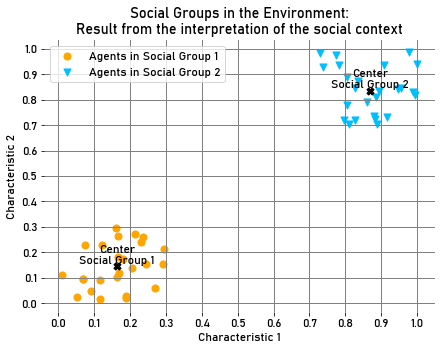

Wealth Plots


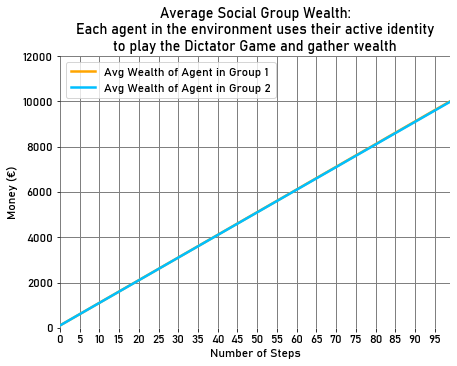

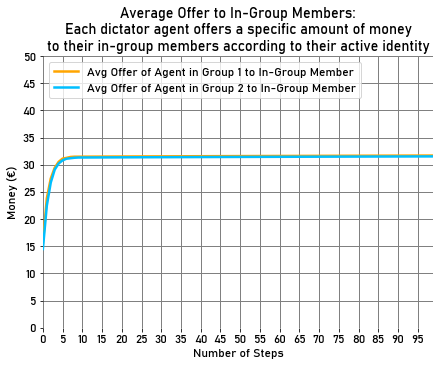

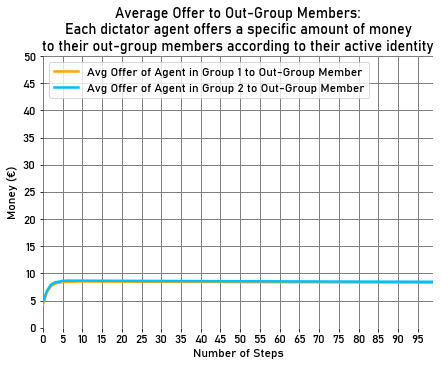

Salience Plots


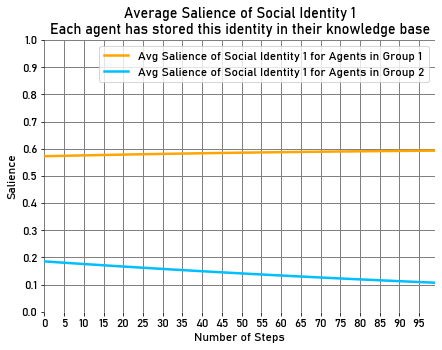

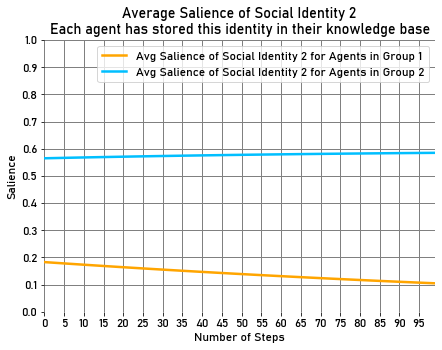

Accessibility Plots


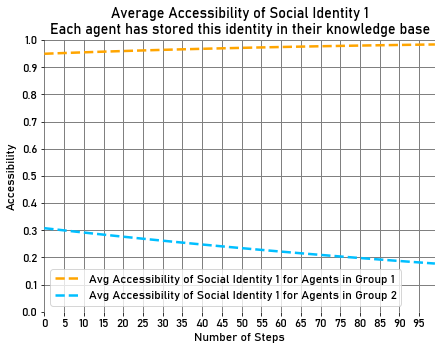

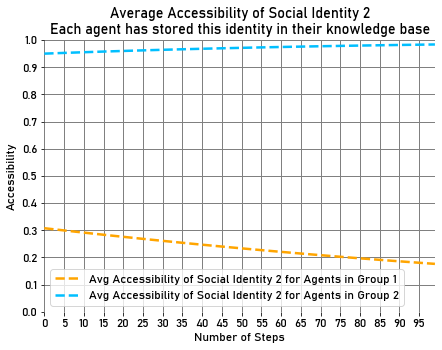

In [5]:
#Restarting the simulation
colors = ["orange", "deepskyblue"]
numRuns = 30
agents = initAgentsLoop(50, 0.5)
context = initContextLoop(2)
addScenarioAgents(agents)
scenario = DictatorGame(20, 100, -0.1, 0.1)
cycleScenario()
printClustering()
#Plots
print("Wealth Plots")
showAverageWealthGroupsPlots()
showAverageOffersInGroupsPlots()
showAverageOffersOutGroupsPlots()
print("Salience Plots")
showSalienceAccessibilityPlots(True)
print("Accessibility Plots")
showSalienceAccessibilityPlots(False)